In [201]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from bs4 import BeautifulSoup
import requests
import json

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [168]:
chennai_df = pd.read_csv('chn_companies_coordinates.csv')
chennai_df.head()

,CompanyName,Location,CompaniesList,longitude,latitude
0,Tidel Park,Taramani,"Cisco Systems, Hexaware Technologies, Sify, Te...",80.240407,12.984907
1,Olympia Tech Park,Guindy,"HP, Verizon, ABN Amro, Visteon, Hewitt, Merril...",80.220365,13.008710
2,SRM Tech Park,Potheri,SRM Institute of Science and Technology,80.045089,12.825011
3,Bahwan CyberTek IT Park,Thorappakkam,"Zafin Labs, Beroe Consulting India, Identive T...",80.278470,13.087840
4,IITM Research Park,Taramani,"Chakra Network Solutions, Saint-Gobain, Centre...",80.240407,12.984907


In [169]:
from geopy.geocoders import Nominatim 

address = 'Chennai'

geolocator = Nominatim(user_agent="chennai_explorer")

location = geolocator.geocode(address)

print(location.latitude, location.longitude)

13.0801721 80.2838331


In [170]:
import folium # map rendering library

map_chennai = folium.Map(location=[location.latitude, location.longitude], zoom_start=11)

for index, row in chennai_df.iterrows():
    label = '{}{}'.format(row.CompanyName, row.Location)
    popup_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row.latitude, row.longitude],
        radius=5,
        popup=popup_label,
        label=popup_label,
        color='green',
        fill=True,        
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai) 

map_chennai

In [171]:
CLIENT_ID = '0SFWND5UEBSAUFKQHV15VINMGVUT5CGTP42VZIJC52GCOKQG'
CLIENT_SECRET = 'BV22D1J3PF05NUM0DWJIZCBKP1PYEFGWG0513R1DKR5J2ONX'
VERSION = '20190625'
LIMIT = 100

In [172]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [173]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [174]:
chennai_venues = getNearbyVenues(names=chennai_df['CompanyName'], latitudes=chennai_df['latitude'], longitudes=chennai_df['longitude'])

chennai_venue_categories = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

chennai_venue_categories['Location'] = chennai_venues['Location']

chennai_grouped = chennai_venue_categories.groupby('Location').mean().reset_index()

chennai_grouped.head()

,Location,ATM,Accessories Store,Afghan Restaurant,Arcade,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Spa,Sporting Goods Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar
0,A.R Foundations - Acropolis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0
1,ASV suntech Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,Akshaya Homes - stanz park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,Alliance Galleria,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0
4,Alliance Orchid Tech Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [175]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [176]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Location'] = chennai_grouped['Location']

for ind in np.arange(chennai_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)
    
venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A.R Foundations - Acropolis,Flea Market,Vegetarian / Vegan Restaurant,Indian Restaurant,Juice Bar,Whisky Bar,Coworking Space,Department Store,Dessert Shop,Electronics Store,Farmers Market
1,ASV suntech Park,Platform,Indian Restaurant,Hotel,Moving Target,Convenience Store,Farmers Market,Cosmetics Shop,Coworking Space,Department Store,Dessert Shop
2,Akshaya Homes - stanz park,Platform,Indian Restaurant,Hotel,Moving Target,Convenience Store,Farmers Market,Cosmetics Shop,Coworking Space,Department Store,Dessert Shop
3,Alliance Galleria,Hotel,Hyderabadi Restaurant,Train Station,Afghan Restaurant,Bus Station,Flea Market,Coworking Space,Department Store,Dessert Shop,Electronics Store
4,Alliance Orchid Tech Park,Seafood Restaurant,Juice Bar,Chettinad Restaurant,Food Court,Concert Hall,Fast Food Restaurant,Whisky Bar,Cosmetics Shop,Coworking Space,Department Store


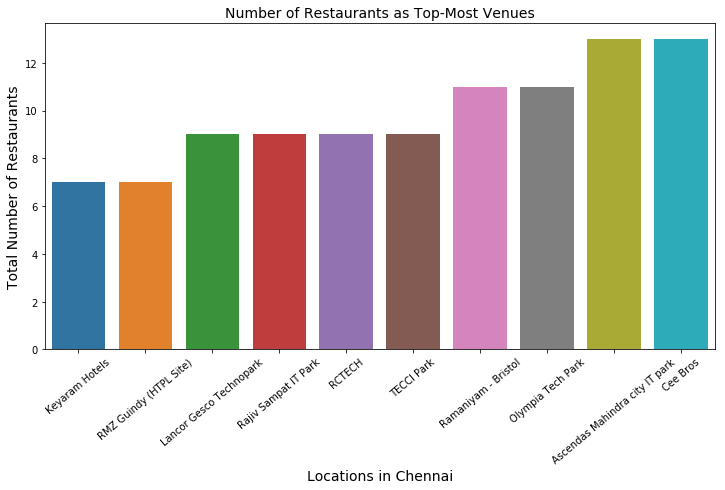

In [177]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

chn_restaurant_by_location = chennai_venues.groupby(['Location'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant') | x.str.contains('Hotel')].count())

chn_restaurant_by_location_df = chn_restaurant_by_location.to_frame().reset_index()

chn_restaurant_by_location_df.columns = ['Location', 'Number of Restaurant']

chn_restaurant_by_location_df.sort_values('Number of Restaurant', inplace=True)

chn_restaurant_by_location_df.index = np.arange(1, len(chn_restaurant_by_location_df) + 1)

chn_restaurant_by_location_df = chn_restaurant_by_location_df.tail(10)

fig = plt.figure(figsize=(12,6))

bar = sns.barplot(x='Location', y='Number of Restaurant', data=chn_restaurant_by_location_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("Locations in Chennai", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)

plt.show()

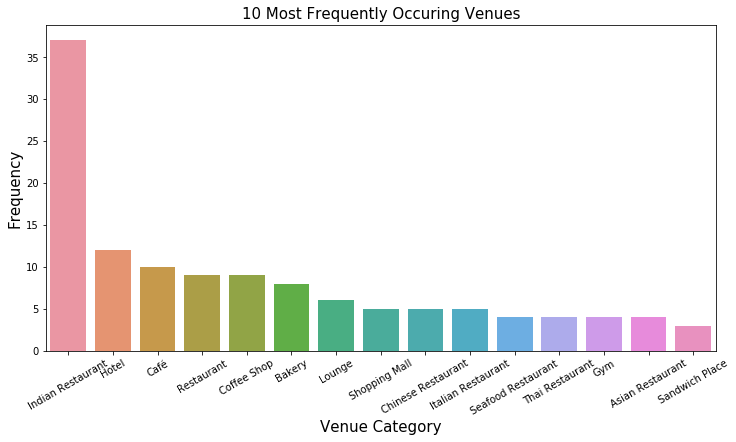

In [179]:
import seaborn as sns

chn_top_10_location = chennai_venues[chennai_venues['Location'].isin(chn_restaurant_by_location_df['Location'].values)]

chn_top_10_venues = chn_top_10_location['Venue Category'].value_counts()[0:15].to_frame(name='frequency').reset_index()

chn_top_10_venues.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)

fig = plt.figure(figsize=(12,6))

s=sns.barplot(x="Venue_Category", y="Frequency", data=chn_top_10_venues)

s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=200)
plt.show()

In [180]:
from sklearn.cluster import KMeans

chn_location_to_compare = chennai_grouped[chennai_grouped['Location'].isin(chn_top_10_location['Location'].values)]

chn_clustered = chn_location_to_compare.drop('Location', 1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(chn_clustered)

print ("Check the 4 Cluster labels :",  kmeans.labels_[0:10])

Check the 4 Cluster labels : [2 2 1 3 1 0 1 0 1 0]


In [200]:
final_df = venues_sorted[venues_sorted['Location'].isin(chn_top_10_location['Location'].values)]

final_df.insert(1, 'Cluster Label', kmeans.labels_)

final_df = pd.merge(chennai_df, final_df, left_on='CompanyName', right_on='Location', how='inner')

final_df= final_df.drop(['Location_y'], axis=1)

final_df

,CompanyName,Location_x,CompaniesList,longitude,latitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Olympia Tech Park,Guindy,"HP, Verizon, ABN Amro, Visteon, Hewitt, Merril...",80.220365,13.008710,1,Hotel,Indian Restaurant,Restaurant,Whisky Bar,Lounge,Concert Hall,Café,Bus Station,Dessert Shop,Italian Restaurant
1,RMZ Guindy (HTPL Site),Guindy,NaN,80.219440,13.008060,1,Indian Restaurant,Whisky Bar,South Indian Restaurant,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Lounge,Coffee Shop,Bus Station,Gym Pool
2,RCTECH,"3D, Mercury Apartments, Pantheon Road, Egmore,...",NaN,80.255560,13.071670,0,Indian Restaurant,Shopping Mall,Seafood Restaurant,Bakery,Coffee Shop,Café,Kebab Restaurant,Sandwich Place,Fast Food Restaurant,Museum
3,Cee Bros,76 Anna salai Teynampet,NaN,80.245197,13.034506,2,Indian Restaurant,Lounge,Café,Burger Joint,Chinese Restaurant,Pizza Place,Italian Restaurant,Restaurant,Sushi Restaurant,Asian Restaurant
4,Rajiv Sampat IT Park,402/403 Pantheon Rd Egmore,NaN,80.255560,13.071670,0,Indian Restaurant,Shopping Mall,Seafood Restaurant,Bakery,Coffee Shop,Café,Kebab Restaurant,Sandwich Place,Fast Food Restaurant,Museum
5,Keyaram Hotels,1 Harrington Rd Chetpet,NaN,80.240830,13.070000,1,Indian Restaurant,Hotel,Coffee Shop,Café,Burger Joint,Dessert Shop,Department Store,Concert Hall,Chinese Restaurant,Restaurant
6,Lancor Gesco Technopark,Alwarpet,NaN,80.254549,13.033860,3,Japanese Restaurant,Bakery,Café,Restaurant,Chinese Restaurant,Sandwich Place,Food & Drink Shop,Indian Restaurant,Italian Restaurant,Juice Bar
7,Ramaniyam - Bristol,Guindy,"Airtel, India Property, HQ10",80.220365,13.008710,1,Hotel,Indian Restaurant,Restaurant,Whisky Bar,Lounge,Concert Hall,Café,Bus Station,Dessert Shop,Italian Restaurant
8,Ascendas Mahindra city IT park,Mahindra city,NaN,80.221951,12.979777,2,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Restaurant,Gym,Gift Shop,Market,Fast Food Restaurant,Department Store,Convenience Store
9,TECCI Park,"OMR,Karapakkam,Chennai-600083","Uninor, Vestas, Valeo, First source, Qmax, Pat...",80.252000,13.069700,0,Indian Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Shopping Mall,Café,Kebab Restaurant,Whisky Bar,Coworking Space,Department Store,Dessert Shop
